## Setup Environment

In [1]:
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer 
from rank_bm25 import BM25Okapi
tqdm.pandas()

import os
import nltk
import pickle
import pandas as pd
import seaborn as sns
import string
import re
import numpy as np
pd.set_option('display.max_colwidth', 1)

ModuleNotFoundError: ignored

In [ ]:
!pip install rank_bm25

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
drive.mount('/content/gdrive')

## Data Preview

In [ ]:
with open('/content/gdrive/MyDrive/NLC/Codes/preprocessed_newsqa_v2.pkl', 'rb') as f:
  data_dict = pickle.load(f)
  df = pd.DataFrame.from_dict(data_dict)

In [ ]:
df = df.sample(frac=0.10, random_state=2021)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039 entries, 18160 to 16089
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   context        3039 non-null   object
 1   question       3039 non-null   object
 2   answer         3039 non-null   object
 3   answer_loc     3039 non-null   object
 4   ans_start_loc  3039 non-null   object
 5   ans_end_loc    3039 non-null   object
dtypes: object(6)
memory usage: 166.2+ KB


In [ ]:
df.head(100)

context  ... answer_len
18160  washington ( cnn ) -- the u.s. government has charged an international arms dealer with conspiring to sell a rebel group millions of dollars in weapons " to be used to kill americans in colombia , " federal prosecutors announced tuesday.viktor bout is accused of selling missiles , rockets and other weapons to farc , a colombian rebel group.viktor bout , who was recently captured in thailand , had agreed to sell the revolutionary armed forces of colombia ( farc ) surface-to-air missiles , armor-piercing rocket launchers , " ultralight " airplanes , unmanned aerial vehicles , and other weapons , the u.s. department of justice said in a news release.there was no immediate public response from bout , who remains in custody in thailand.federal authorities unsealed an indictment charging bout with four terrorism offenses : conspiracy to kill u.s. nationals , conspiracy to kill u.s. officers or employees , conspiracy to acquire and use an anti-aircraft missile , and conspiracy to provide material support or resources to a designated foreign terrorist organization.farc is designated a terrorist organization by the u.s. state department.justice department officials said they are seeking bout 's extradition to the united states.the indictment alleges that bout made agreements with farc between november 2007 and march of this year.in their news release , federal prosecutors said bout agreed to sell weapons " to two confidential sources " working with the u.s. drug enforcement administration , who had " represented that they were acquiring these weapons for the farc , with the specific understanding that the weapons were to be used to attack united states helicopters in colombia . " the news release also refers to a " covertly recorded meeting in thailand on march 6 , 2008 . " " with the unsealing of this indictment , we are one step closer to ensuring bout has delivered his last load of high-powered weaponry and armed his final terrorist , " dea acting administrator michele m. loenhart said in the news release.attorney general michael mukasey last month singled out bout as a leading example of a new breed of organized crime leaders who operate across international boundaries to amass wealth without regard to political ideology . " viktor bout has long been considered by the international community as one of the world 's most prolific arms traffickers , " u.s. attorney michael garcia said in the news release tuesday.bout 's assets in the united states were frozen in 2004 after he allegedly shipped weapons to liberia in violation of u.s. government restrictions .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
df['context_wo_punc'] = df['context'].progress_apply(remove_punctuations)
df['answer_wo_punc'] = df['answer'].progress_apply(remove_punctuations)

  0%|          | 0/3039 [00:00<?, ?it/s]

  0%|          | 0/3039 [00:00<?, ?it/s]

In [ ]:
df['context_len'] = df['context_wo_punc'].progress_apply(word_len)
df['answer_len'] = df['answer_wo_punc'].progress_apply(word_len)

  0%|          | 0/3039 [00:00<?, ?it/s]

  0%|          | 0/3039 [00:00<?, ?it/s]

In [ ]:
def word_len(text):
  return len(text.split())

In [ ]:
df['context_len'].mean()

620.6265218821981

In [ ]:
df['answer_len'].mean()

4.706482395524843

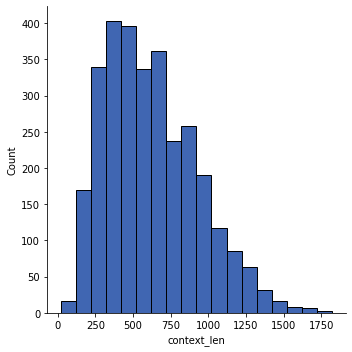

In [ ]:
sns.displot(df['context_len'], binwidth=100, color='#003399')

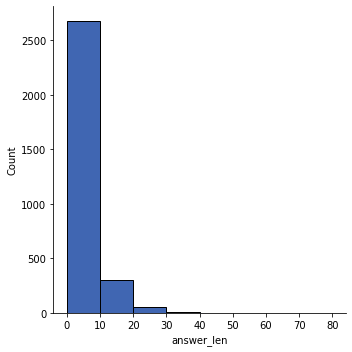

In [ ]:
sns.displot(df['answer_len'], binwidth=10, color='#003399')

## Preprocessing

In [ ]:
def remove_punctuations(text):
  return text.translate(str.maketrans('', '', string.punctuation))

lemmatizer = WordNetLemmatizer()
def lemmatize_and_remove_stopwords(text):
  text_tokens = word_tokenize(text)
  processed_tokens = [lemmatizer.lemmatize(word.strip()) for word in text_tokens if not word in stopwords.words()]
  return ' '.join(processed_tokens)

# def remove_duplicated_spaces(text):
#   return re.sub(' +', ' ', text)

# def remove_digits(text):
#   remove_digits = str.maketrans('', '', string.digits)
#   return text.translate(remove_digits)

# def remove_stopwords(text):
#   text_tokens = word_tokenize(text)
#   tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
#   return ' '.join(tokens_without_sw)

def preprocess(text):
  text = remove_punctuations(text)
  text = lemmatize_and_remove_stopwords(text)
  return text

In [ ]:
df['question_cleaned'] = df['question'].progress_apply(lambda x: preprocess(x))

  0%|          | 0/3039 [00:00<?, ?it/s]

In [ ]:
df['context_cleaned'] = df['context'].progress_apply(lambda x: preprocess(x))

  0%|          | 0/3039 [00:00<?, ?it/s]

In [ ]:
df.to_pickle('/content/gdrive/MyDrive/NLC/Codes/Information Retrieval/cleaned_df_4nov.pkl')

## Information Retrieval

In [ ]:
with open('/content/gdrive/MyDrive/NLC/Codes/Information Retrieval/cleaned_df_3nov.pkl', 'rb') as file:
  df = pickle.load(file)

In [ ]:
df.head(50)

,context,question,answer,answer_loc,ans_start_loc,ans_end_loc,question_cleaned,context_cleaned,question_w2v,context_w2v,context_id
18160,washington ( cnn ) -- the u.s. government has ...,what country is bout associated with ?,"thailand ,",66 67,66,67,country bout associated,washington cnn u government charged internatio...,"[0.18707748, -0.003414889, -0.19330478, 0.0399...","[0.14379882394615937, 0.10224534643797314, -0....",18160
26351,( cnn ) -- libya celebrated wildly thursday wi...,what awaits the new government ?,the nation-building equivalent of a huge pile ...,35 65,35,65,awaits new government,cnn libya celebrated wildly thursday news long...,"[0.033388626, 0.13975118, -0.15158825, 0.10252...","[0.110371694, 0.024907766, -0.10983571, 0.0752...",26351
8920,"santiago , chile ( reuters ) -- chile called h...",what has bubbled away ?,dispute over their sea border,408 412,408,412,bubbled away,santiago chile reuters chile called home ambas...,"[0.18205965, -0.05689264, -0.017133806, -0.064...","[0.15287347575132654, 0.04046634149272801, -0....",8920
13262,( cnn ) -- the attack on a danish political ca...,whose home was attacked ?,kurt westergaard 's,37 39,37,39,whose home attacked,cnn attack danish political cartoonist run tot...,"[0.23826756, 0.019797066, -0.01485115, 0.05847...","[0.2092656831048, 0.06817306975840513, -0.0523...",13262
1857,jerusalem ( cnn ) -- some 43 years after a bea...,who is to play in tel aviv ?,paul mccartney,23 24,23,24,play tel aviv,jerusalem cnn 43 year beatles concert accordin...,"[0.18783177, 0.051206704, -0.06476163, -0.0087...","[0.16981994, 0.01285565, -0.053904608, 0.06280...",1857
15473,"( aol autos ) -- big al , the used car dealer ...",how much can i save ?,from two to eight percent,1045 1049,1045,1049,much save,aol auto big used car dealer small lot corner ...,"[0.22323456, -0.21673198, -0.063700795, -0.018...","[0.19289508, 0.015822424, -0.03859321, 0.08062...",15473
29201,( cnn ) -- former vice presidential candidate ...,what is mccain facing ?,a primary challenge from former rep. j.d . hay...,58 66,58,66,mccain facing,cnn former vice presidential candidate sarah p...,"[-0.008742877, 0.15859932, -0.11639189, 0.0529...","[0.14241043762025282, 0.1069617131477378, -0.0...",29201
23949,( cnn ) -- anna nicole smith 's longtime partn...,what were all three charged with giving ?,""" prescribing , administering or dispensing a ...",274 287,274,287,three charged giving,cnn anna nicole smith longtime partner attorne...,"[0.18367212, 0.110498466, -0.073075555, 0.0423...","[0.19644195, 0.0852848, -0.06726097, 0.1182472...",23949
26381,"london , england ( cnn ) -- britain 's prince ...",where was the boat ?,"hundreds of miles northeast of barbados ,",110 116,110,116,boat,london england cnn britain prince william help...,"[0.2924102, -0.26691806, 0.036713533, -0.07334...","[0.18801132, -0.03268504, -0.028823547, 0.0494...",26381
6063,( cnn ) -- president obama 's economic stimulu...,what did obama make a push for ?,remove the family planning provision,741 745,741,745,obama make push,cnn president obama economic stimulus plan cle...,"[-0.016346898, 0.14039655, -0.19863898, 0.0919...","[0.0972692, 0.06275094, -0.055103175, 0.067182...",6063


In [ ]:
df.iloc[1]['context_cleaned']

'cnn libya celebrated wildly thursday news longtime dictator moammar gadhafi deathbut aftermath party country new leader awaken friday morning nationbuilding equivalent huge pile dirty broken dish kitchen mention bitter guest nt quite ready leave expert sayalthough gadhafi death probably possibility insurgency could sapped new government time energy little heal myriad division within country said fawaz gerges director middle east centre london school economics challenge much greater basically celebration seeing today western capital said think morning wake libya changed little term really mending rift inside country libyan celebrate death longtime dictatorthose rift include sharp division among rebel group leader western city misrata refused recognize easternbased national transitional council country new government gerges saidand gadhafi dead primary unifying force held rebel together gone according stratfor analyst kamran bokhari thing held rebel together presence moammar gadhafi eve

### 1. Word2Vec

In [ ]:
# Combining corpus and queries for training
combined_df = pd.concat([df['context_cleaned'], df['question_cleaned']])

In [ ]:
combined_df

18160    washington cnn u government charged internatio...
26351    cnn libya celebrated wildly thursday news long...
8920     santiago chile reuters chile called home ambas...
13262    cnn attack danish political cartoonist run tot...
1857     jerusalem cnn 43 year beatles concert accordin...
                               ...                        
6482                                        result autopsy
11045                              child ready potty train
5704                                local swedish designer
20902                              president bush disagree
16089                                     uribite response
Length: 6078, dtype: object

In [ ]:
from gensim.models import Word2Vec

# Creating data for the model training
w2v_train_data = []
for i in combined_df:
    w2v_train_data.append(i.split())

# Training a word2vec model from the given data set
w2v_model = Word2Vec(w2v_train_data, size=300, min_count=2,window=5, sg=1,workers=4)

In [ ]:
# Vocabulary size
print('Vocabulary size:', len(w2v_model.wv.vocab))

Vocabulary size: 36466


In [ ]:
# Function returning vector reperesentation of a document
def get_embedding_w2v(doc_tokens):
    embeddings = []
    if len(doc_tokens)<1:
        return np.zeros(300)
    else:
        for tok in doc_tokens:
            if tok in w2v_model.wv.vocab:
                embeddings.append(w2v_model.wv.word_vec(tok))
            else:
                embeddings.append(np.random.rand(300))
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)

# Getting Word2Vec Vectors for Testing Corpus and Queries
df['question_w2v']=df['question_cleaned'].apply(lambda x :get_embedding_w2v(x.split()))
df['context_w2v']=df['context_cleaned'].apply(lambda x :get_embedding_w2v(x.split()))

In [ ]:
df['context_id'] = df.index

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def in_top_5_w2v(question_vec, truth_context_id):
  scores = df['context_w2v'].apply(lambda x: cosine_similarity(x.reshape(1, -1), question_vec.reshape(1, -1))[0][0])
  # for i in scores:
  #   print(i[0])
  scores_zipped = tuple(zip(df['context_id'],scores))
  sorted_scores = sorted(scores_zipped, key = lambda x: x[1], reverse=True)
  top5_context_ids = [i[0] for i in sorted_scores[:5]]
  return truth_context_id in top5_context_ids

In [ ]:
in_top_5_w2v(df.iloc[4]['question_w2v'], df.iloc[4]['context_id'])

Actual Context ID: 1857
[(1676, 0.8947346210479736), (23742, 0.8947346210479736), (2709, 0.8817159533500671), (14919, 0.8817159533500671), (435, 0.8817159533500671)]


In [ ]:
total_counter = 0
correct_top5_counter = 0

for idx, row in df.iterrows():
  if in_top_5_w2v(row['question_w2v'], row['context_id']):
    correct_top5_counter += 1
  total_counter += 1
  print(f"Index: {total_counter}/{len(df)}, Current Accuracy: {round(correct_top5_counter/total_counter,5)}")

Index: 1/3039, Current Accuracy: 0.0
Index: 2/3039, Current Accuracy: 0.0
Index: 3/3039, Current Accuracy: 0.0
Index: 4/3039, Current Accuracy: 0.0
Index: 5/3039, Current Accuracy: 0.0
Index: 6/3039, Current Accuracy: 0.0
Index: 7/3039, Current Accuracy: 0.0
Index: 8/3039, Current Accuracy: 0.125
Index: 9/3039, Current Accuracy: 0.22222
Index: 10/3039, Current Accuracy: 0.2
Index: 11/3039, Current Accuracy: 0.18182
Index: 12/3039, Current Accuracy: 0.16667
Index: 13/3039, Current Accuracy: 0.15385
Index: 14/3039, Current Accuracy: 0.14286
Index: 15/3039, Current Accuracy: 0.13333
Index: 16/3039, Current Accuracy: 0.125
Index: 17/3039, Current Accuracy: 0.11765
Index: 18/3039, Current Accuracy: 0.11111
Index: 19/3039, Current Accuracy: 0.10526
Index: 20/3039, Current Accuracy: 0.1
Index: 21/3039, Current Accuracy: 0.14286
Index: 22/3039, Current Accuracy: 0.13636
Index: 23/3039, Current Accuracy: 0.13043
Index: 24/3039, Current Accuracy: 0.125
Index: 25/3039, Current Accuracy: 0.12
Inde

In [ ]:
print(f"Word2Vec IR Accuracy (In Top 5): {round(correct_top5_counter/total_counter,5)}")

Word2Vec IR Accuracy (In Top 5): 0.12142


### 2. Okapi BM25

In [ ]:
bm25_corpus = list(df['context_cleaned'])

tokenized_bm25corpus = [doc.split(" ") for doc in bm25_corpus]

bm25 = BM25Okapi(tokenized_bm25corpus)

In [ ]:
def in_top_5_bm25(question, truth_context_id):
  question = preprocess(question)
  tokenized_question = question.split(" ")
  scores = bm25.get_scores(tokenized_question)
  scores_zipped = tuple(zip(df['context_id'], scores))
  sorted_scores = sorted(scores_zipped, key = lambda x: x[1], reverse=True)
  top5_context_ids = [i[0] for i in sorted_scores[:5]]
  return truth_context_id in top5_context_ids

In [ ]:
def retrieve_context_id_bm25(question):
  question = preprocess(question)
  tokenized_question = question.split(" ")
  scores = bm25.get_scores(tokenized_question)
  scores_zipped = tuple(zip(df['context_id'], scores))
  sorted_scores = sorted(scores_zipped, key = lambda x: x[1], reverse=True)
  return sorted_scores[0][0] 

In [ ]:
def retrieve_and_print_context_bm25(question):
  context_id = retrieve_context_id_bm25(question)
  print(df[df['context_id'] == context_id]['context'].iloc[0])

In [ ]:
total_counter = 0
correct_top5_counter = 0

for idx, row in df.iterrows():
  if in_top_5_bm25(row['question_cleaned'], row['context_id']):
    correct_top5_counter += 1
  total_counter += 1
  print(f"Index: {total_counter}/{len(df)}, Current Accuracy: {round(correct_top5_counter/total_counter,5)}")

Index: 1/3039, Current Accuracy: 1.0
Index: 2/3039, Current Accuracy: 0.5
Index: 3/3039, Current Accuracy: 0.66667
Index: 4/3039, Current Accuracy: 0.75
Index: 5/3039, Current Accuracy: 0.8
Index: 6/3039, Current Accuracy: 0.66667
Index: 7/3039, Current Accuracy: 0.71429
Index: 8/3039, Current Accuracy: 0.75
Index: 9/3039, Current Accuracy: 0.77778
Index: 10/3039, Current Accuracy: 0.7
Index: 11/3039, Current Accuracy: 0.72727
Index: 12/3039, Current Accuracy: 0.75
Index: 13/3039, Current Accuracy: 0.76923
Index: 14/3039, Current Accuracy: 0.78571
Index: 15/3039, Current Accuracy: 0.73333
Index: 16/3039, Current Accuracy: 0.6875
Index: 17/3039, Current Accuracy: 0.70588
Index: 18/3039, Current Accuracy: 0.66667
Index: 19/3039, Current Accuracy: 0.63158
Index: 20/3039, Current Accuracy: 0.65
Index: 21/3039, Current Accuracy: 0.66667
Index: 22/3039, Current Accuracy: 0.68182
Index: 23/3039, Current Accuracy: 0.65217
Index: 24/3039, Current Accuracy: 0.625
Index: 25/3039, Current Accuracy

In [ ]:
print(f"BM25 IR Accuracy (In Top 5): {round(correct_top5_counter/total_counter,5)}")

BM25 IR Accuracy (In Top 5): 0.60875


In [ ]:
retrieve_and_print_context_bm25('what happened at hoover dam on friday?')

( cnn ) -- a bus carrying chinese tourists overturned friday near hoover dam , killing at least seven people and injuring at least nine , an arizona department of public safety spokesman said.authorities work on the crash scene friday on u.s. 93 in white hills , arizona , near hoover dam.the accident happened at 4 p.m. on u.s. 93 at mile marker 27 , about 27 miles south of hoover dam , said lt. james warriner.the dead lay in body bags on the roadway near the bus , which was on its side across both lanes and onto the shoulder of the highway.initial reports from the scene indicated rescuers had difficulty communicating with the passengers , all of them chinese nationals.five of the injured were taken to kingman regional medical center , where one was in critical condition and four were in serious condition , said ryan kennedy , executive director of operations.rick plummer , a spokesman for university medical center in las vegas , said the hospital received five victims by helicopter , o

In [ ]:
retrieve_and_print_context_bm25('chihuahua accident kentucky')

( cnn ) -- a kentucky chihuahua is expected to make a full recovery after a freak accident that left a large barbecue fork lodged in his head for days , according to the animal hospital where he was treated.during a family gathering two weeks ago , 12-week-old smokey was waiting to be fed as his owner used the fork to shoo another dog away from smokey 's food , su smith , vice president of cumberland valley animal hospital in london , kentucky , wrote in an article on the hospital 's web site.as owner vickie brumley of manchester , kentucky , waved the fork , the handle broke off and the fork end was flung through the air , embedding itself several inches into smokey 's head.smokey immediately ran into the woods , smith wrote . for two days , his owner 's family searched for him despite bad weather and finally came to the conclusion that he had either died of his injury or been killed by wildlife.brumley 's brother , hughie wagers , was visiting his sister and sitting on the porch when

In [ ]:
retrieve_and_print_context_bm25('how to deal with cholesterol problem?')

atlanta , georgia ( cnn ) -- lets face it : all the information around cholesterol makes it something of a confusing topic . not only do we make our own cholesterol , but we also must have it to produce other important body assets , such as cell membranes and certain types of hormones . " good " cholesterol vs. " bad " cholesterol and all the associated numbers can be confusing.so it 's a bodily must-have . but we also augment that inner cholesterol machine by eating foods high in saturated fats such as whole dairy products and red meats and probably half the offerings at any fast-food spot . add to that the fact many people simply overproduce or underproduce cholesterol because of their genes -- and that is just the beginning of the conundrum over cholesterol.but while many ca n't quite wrap their brain around it , the reality is many of us are affected by it , and not in a good way . according to the american heart association , almost half the adult female population in the united s

In [ ]:
retrieve_and_print_context_bm25('could omaha shooting be prevented?')

washington ( cnn ) -- some experts are skeptical that anything could have stopped robert hawkins from going on a murderous rampage at an omaha , nebraska , shopping mall on wednesday.a police car sits outside the westroads mall in omaha , nebraska , on thursday . " this is not something that anybody can reasonably anticipate , " said don greene , a former fbi agent who has written a book on mall security . " if the people closest to him did n't see any indicators or signs that he was going to go off so drastically ... how is some public safety officer supposed to recognize this person ? " greene asked.in fact , security at omaha 's westroads mall did find hawkins ' behavior suspicious before the shooting , omaha police chief thomas warren said thursday.mall surveillance initially flagged hawkins " based on his actions " when he entered the mall through the von maur store 's main entrance on the second floor , warren said . he said hawkins exited quickly after entering , then re-entered

In [ ]:
retrieve_and_print_context_bm25('why was ciro fired?')

( cnn ) -- juventus have sacked coach ciro ferrara after a string of poor results and have installed alberto zaccheroni in the hot seat until the end of the season.ferrara 's position has been threatened after a dismal run which has seen them slip out of contention in the serie a title race as well as being eliminated from the champions league at the group stages.thursday 's 2-1 coppa italia defeat to italian champions inter milan proved the final straw and the club released a statement to confirm his departure and zaccheroni 's arrival . " zaccheroni will take over the team immediately and will guide this afternoon 's training session in vinovo before being officially unveiled to the media , " it read.ferrara joined juve late last season and steered the turin powerhouses to second place in serie a behind inter.but his first full campaign in charge proved challenging after a promising start to the season.the bianconeri have lost five of their last six games in serie a and have slumped 